In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [4]:
print(test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [5]:
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median())) # Fajny pomysł z prezentacji od Julii
df.drop(['Cabin','Name', 'PassengerId', 'Ticket'],axis = 1,inplace=True)
df = df.fillna({"Embarked": "S"})

test['Fare'] = test.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
test['Age'] = test.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
test.drop(['Cabin','Name', 'PassengerId', 'Ticket'],axis = 1,inplace=True)

df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

In [6]:
df['Sex'] = df['Sex'].map({'male':1, 'female':0})

In [7]:
print(df.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
FamilySize    0
dtype: int64


In [8]:
print(test.isnull().sum())

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
FamilySize    0
dtype: int64


In [9]:
df = pd.get_dummies(df, columns=['Embarked', 'Pclass'])

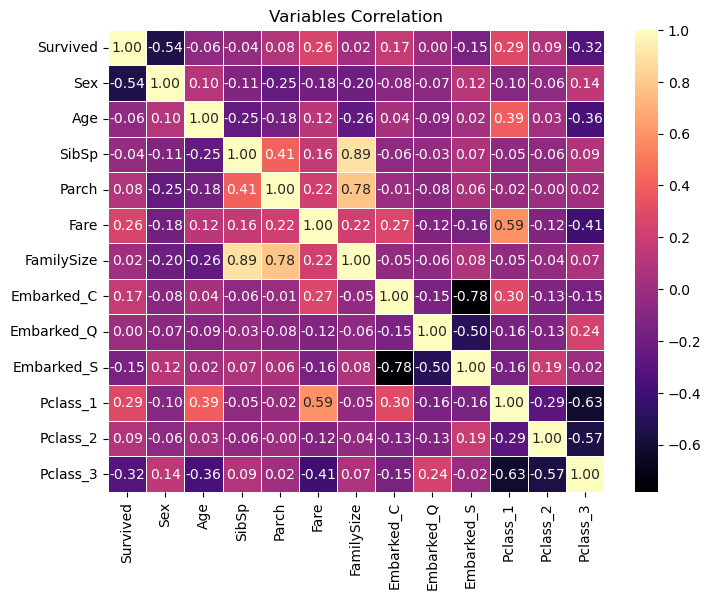

In [10]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='magma', fmt='.2f', linewidths=0.5)
plt.title('Variables Correlation')
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

In [12]:
X = df.drop(columns=['Survived'], axis=1)
y = df['Survived']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
tree.fit(X_train, y_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [15]:
y_pred = tree.predict(X_test)

In [16]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.83      0.66      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.80      0.80       179



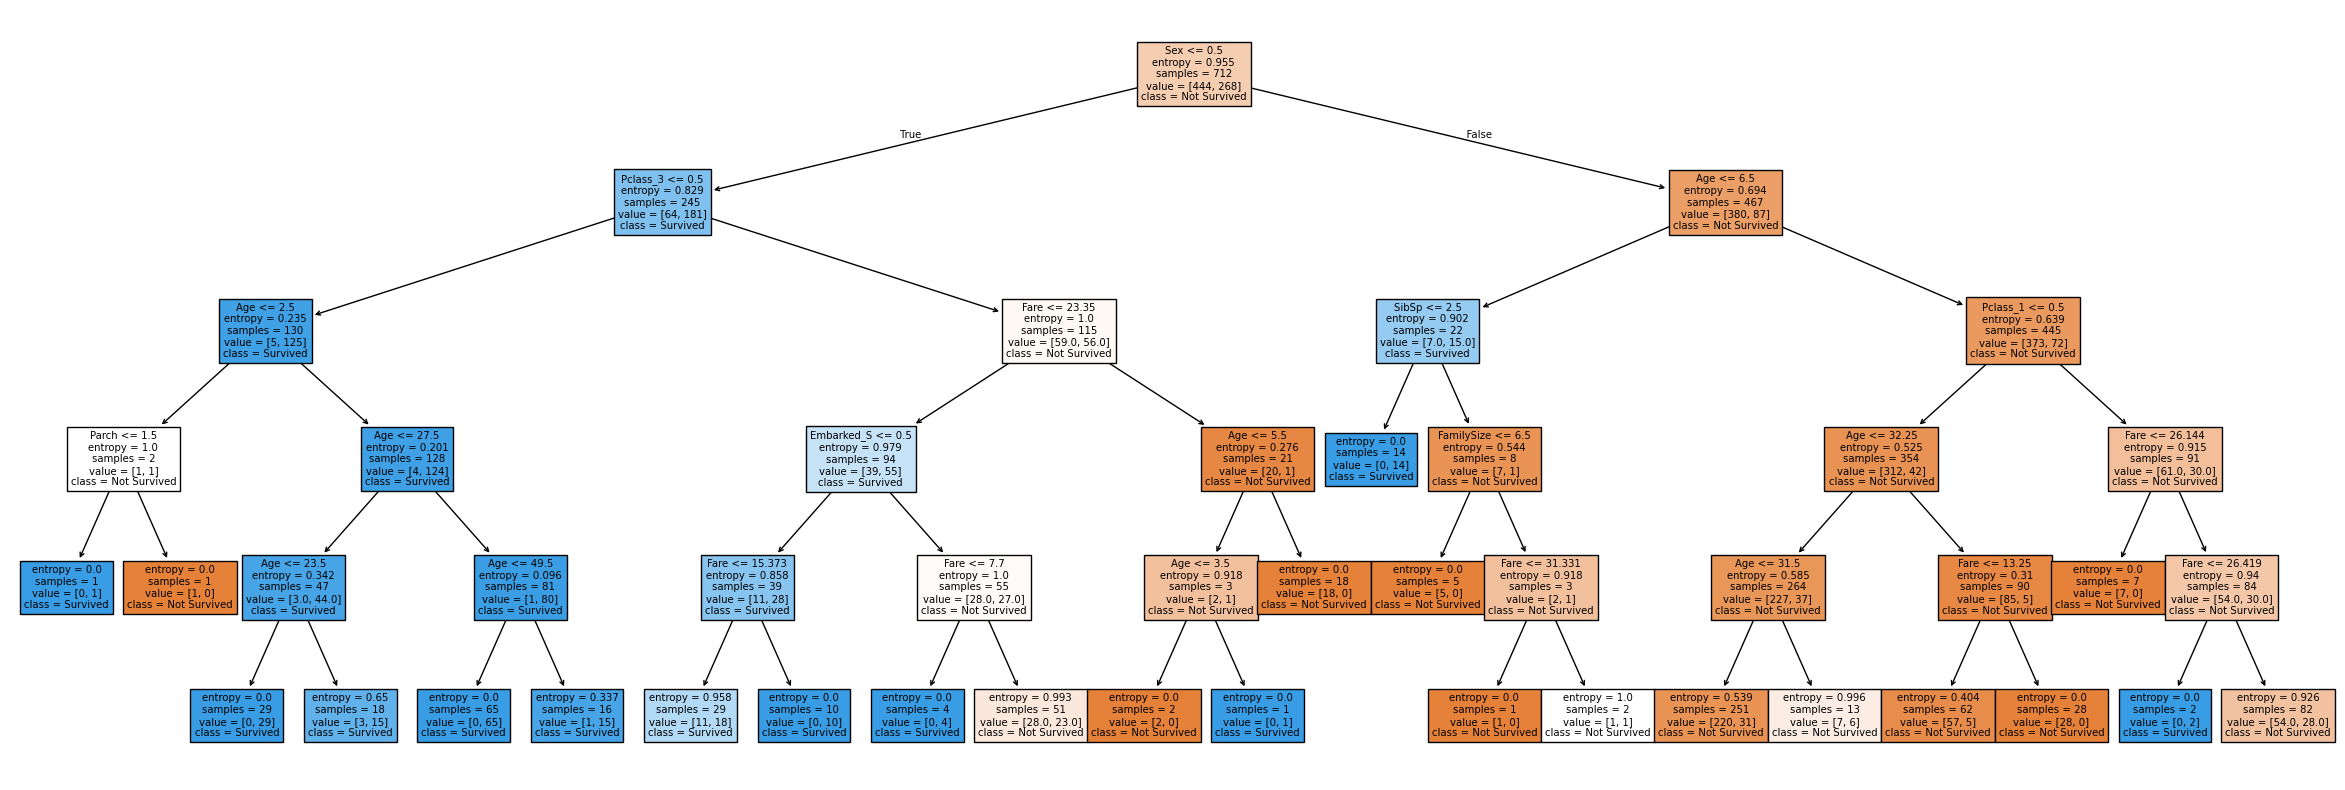

In [17]:
plt.figure(figsize=(30, 10))
plot_tree(tree, feature_names=X.columns, class_names=['Not Survived', 'Survived'], filled=True)
plt.show()


In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
randomForest = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    min_samples_split=10,
    min_samples_leaf=4
)
randomForest.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
y_pred = randomForest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       105
           1       0.84      0.69      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.81       179



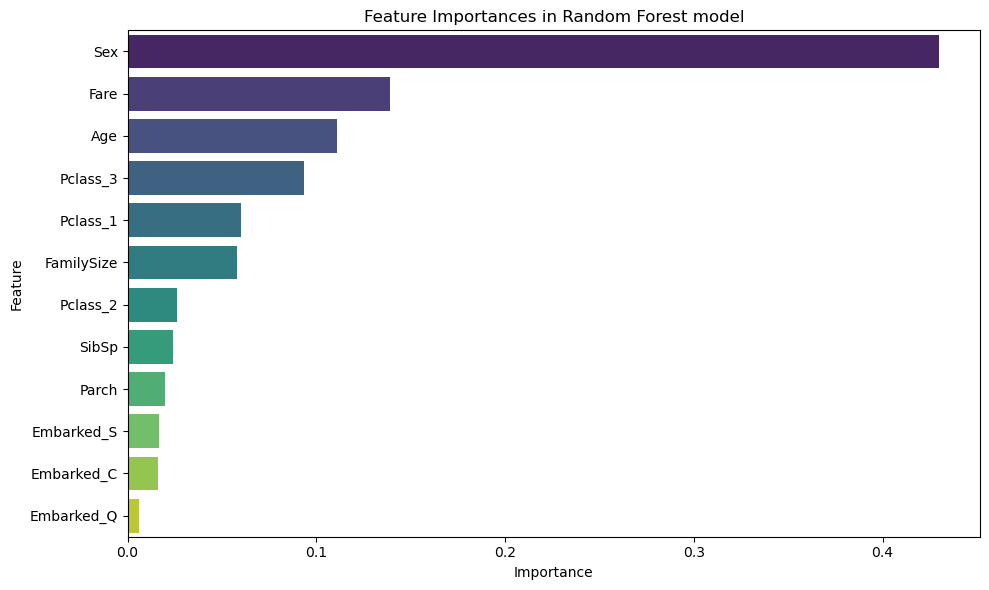

In [21]:
importances = randomForest.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_n = 15
feature_importance_df = feature_importance_df.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    order=feature_importance_df['Feature'],
    palette='viridis'
)
plt.title('Feature Importances in Random Forest model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


We can also use a tree-based model such as LightGBM, a gradient boosting framework that uses tree-based learning algorithms

In [22]:
import lightgbm as lgbm
from sklearn.metrics import accuracy_score

train_data = lgbm.Dataset(data=X_train, label=y_train)
test_data = lgbm.Dataset(data=X_test, label=y_test)

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 500,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'is_unbalance': True,
    'verbose': -1,
}
modelX = lgbm.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[test_data],
    callbacks=[
        lgbm.early_stopping(stopping_rounds=50),
        lgbm.log_evaluation(50),
    ]
)

y_pred = modelX.predict(X_test)
y_pred_class = [1 if p > 0.5 else 0 for p in y_pred]

accuracy = accuracy_score(y_test, y_pred_class)
print(f'Accuracy: {accuracy:.4f}')

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.414896
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.413801
Accuracy: 0.8156


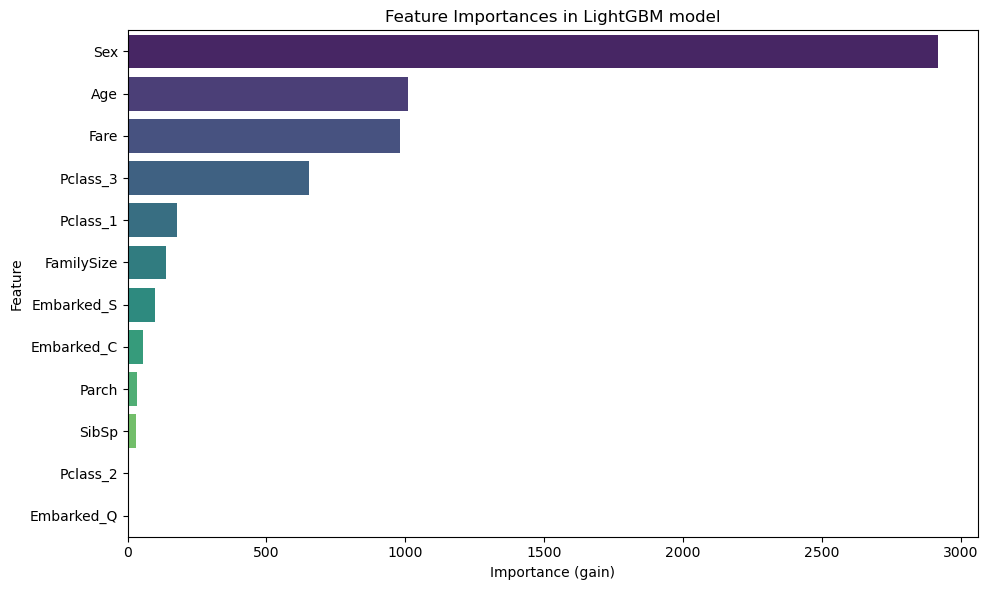

In [23]:
importances = modelX.feature_importance(importance_type='gain')

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])],
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    order=feature_importance_df['Feature'],
    palette='viridis'
)
plt.title('Feature Importances in LightGBM model')
plt.xlabel('Importance (gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
